# Importations

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("data/ai4i2020.csv")
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [3]:
drop_columns = ["UDI", "Product ID", "TWF", "HDF", "PWF", "OSF", "RNF"]
utils_columns = ["Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]"]

# Pre-processing

### TrainTest - Nettoyage - Encodage

In [4]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)

In [5]:
trainset["Machine failure"].value_counts()

Machine failure
0    7736
1     264
Name: count, dtype: int64

In [6]:
testset["Machine failure"].value_counts()

Machine failure
0    1925
1      75
Name: count, dtype: int64

### Features Engineering

In [7]:
def features_engineering(df):
    df['power_machine'] = df['Torque [Nm]'] * (  np.pi * df['Rotational speed [rpm]'] / 30 )
    df['temp_diff'] = df['Process temperature [K]'] - df['Air temperature [K]']
    return df

In [8]:
def imputation(df):
    df = df.drop(columns=drop_columns, axis=1)
    return df

In [9]:
def preprocessing(df):
    df = features_engineering(df)
    df = imputation(df)

    X, y = df.drop("Machine failure", axis=1),  df["Machine failure"]
    print(y.value_counts())
    
    return X, y
    

In [10]:
X_train, y_train = preprocessing(trainset)
X_test, y_test = preprocessing(testset)

Machine failure
0    7736
1     264
Name: count, dtype: int64
Machine failure
0    1925
1      75
Name: count, dtype: int64


# Modelisation

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest

In [12]:
type_order = ["L", "M", "H"]

In [13]:
column_transformer = ColumnTransformer(transformers=[
    ("type_encoder", OrdinalEncoder(categories=[type_order], handle_unknown="use_encoded_value", unknown_value=-1), ["Type"])
], remainder="passthrough")

In [14]:
preprocessor = make_pipeline(
    column_transformer,
    SelectKBest(k="all"),
)

In [15]:
RandomForest = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("rf", RandomForestClassifier(random_state=0, n_jobs=6))
    ])

DecisionTreeC = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("decisionTreeClassifier", DecisionTreeClassifier(random_state=0))
    ])
AdaBoost = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("AdaBoost", AdaBoostClassifier(random_state=0))
    ])
KNNe = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("scaler", StandardScaler()),
    ("KNNe", KNeighborsClassifier())
    ])
xgb_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("xgb", XGBClassifier(random_state=0, n_jobs=6))
    ])

In [16]:
dict_of_models = {'random_forest' : RandomForest, 
                  'decision_tree_classifier' : DecisionTreeC,
                  'xgboost' : xgb_pipe,
                  'AdaBoost' : AdaBoost,
                  'KNNe' : KNNe
                  }

# Evaluation

In [17]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np


In [18]:
def evaluation(model):
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)

    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    

    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4, scoring='f1', train_sizes=np.linspace(0.1 ,1, 10))

    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

In [19]:
def get_feature_importances(pipeline, step_preprocessor, step_model_name):
    step_model_name = pipeline.named_steps[step_model_name]
    feature_names = pipeline.named_steps[step_preprocessor].get_feature_names_out()
    # Récupérer les importances
    importances = step_model_name.feature_importances_
    # Mettre dans un DataFrame et tracer
    pd.DataFrame(importances, index=feature_names, columns=["importance"]).sort_values(by="importance", ascending=False).plot.bar(figsize=(12,5))

random_forest
[[1920    5]
 [  22   53]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1925
           1       0.91      0.71      0.80        75

    accuracy                           0.99      2000
   macro avg       0.95      0.85      0.90      2000
weighted avg       0.99      0.99      0.99      2000

decision_tree_classifier
[[1910   15]
 [  21   54]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1925
           1       0.78      0.72      0.75        75

    accuracy                           0.98      2000
   macro avg       0.89      0.86      0.87      2000
weighted avg       0.98      0.98      0.98      2000

xgboost
[[1918    7]
 [  22   53]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1925
           1       0.88      0.71      0.79        75

    accuracy                           0.99      2000


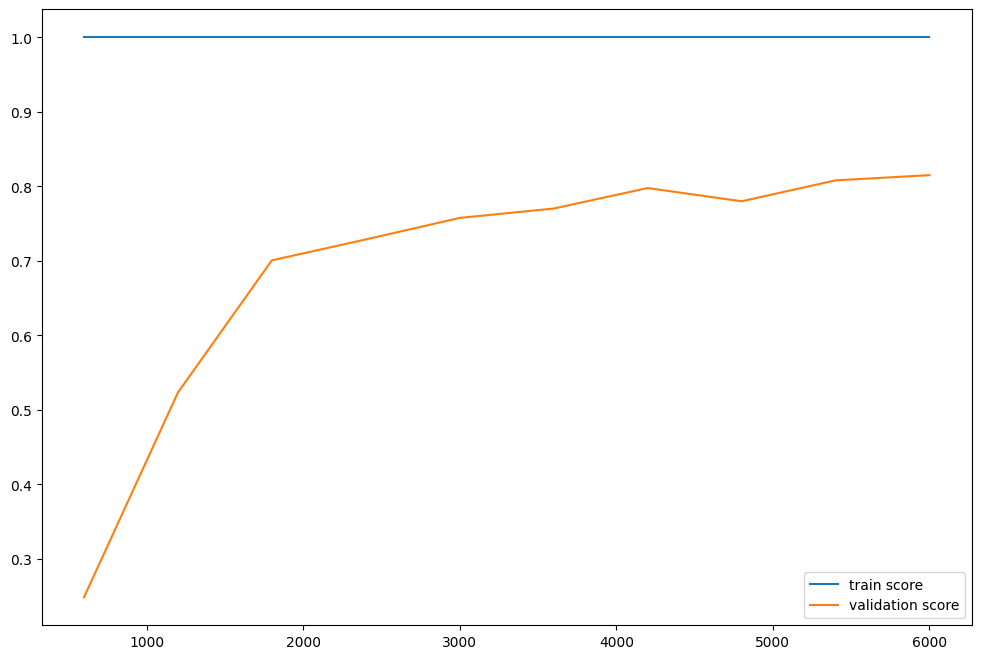

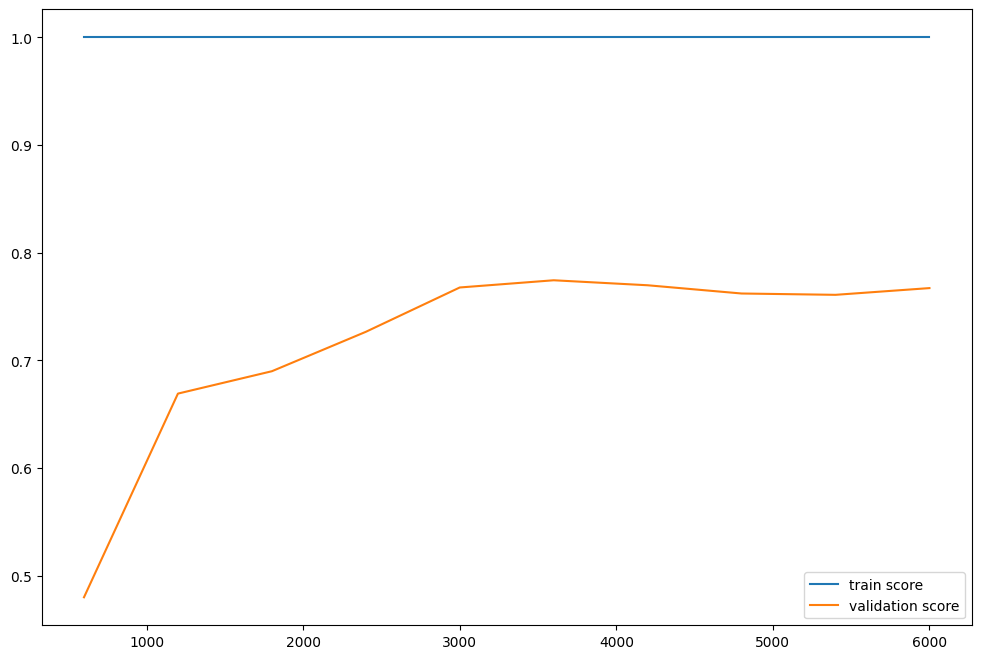

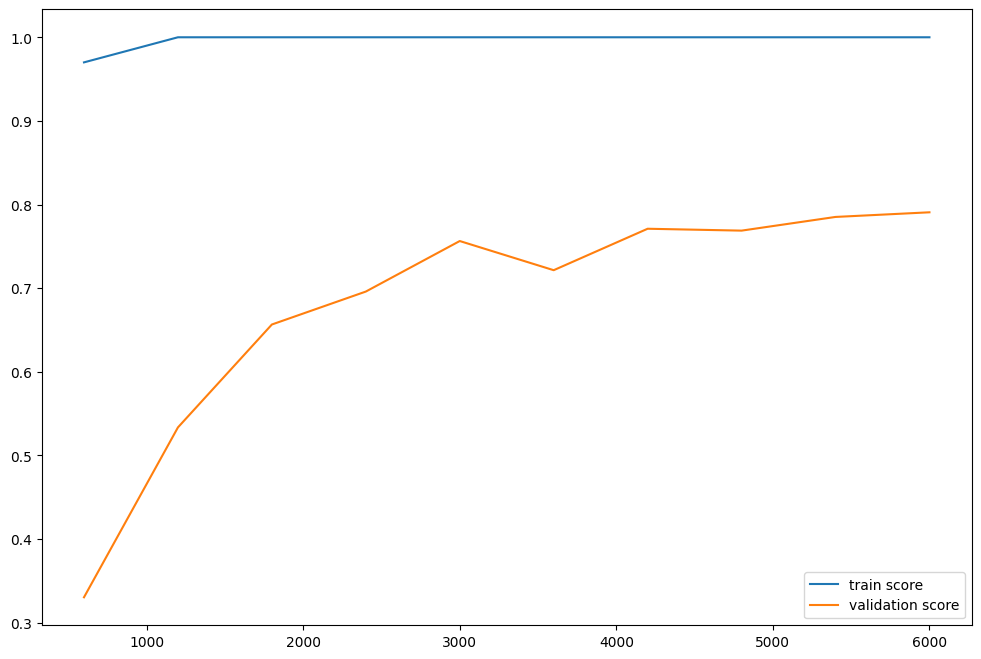

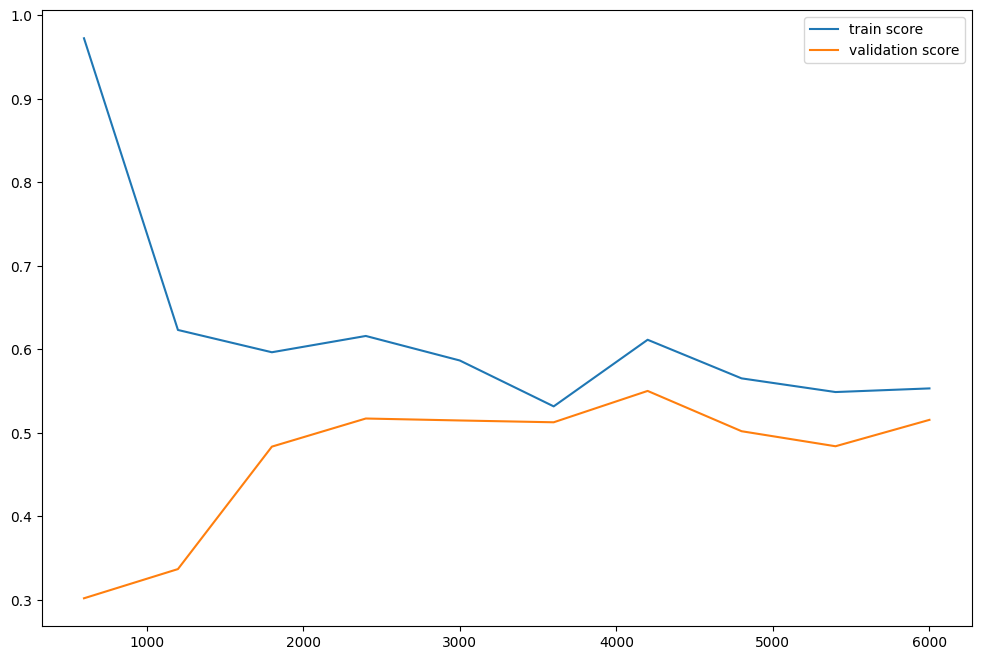

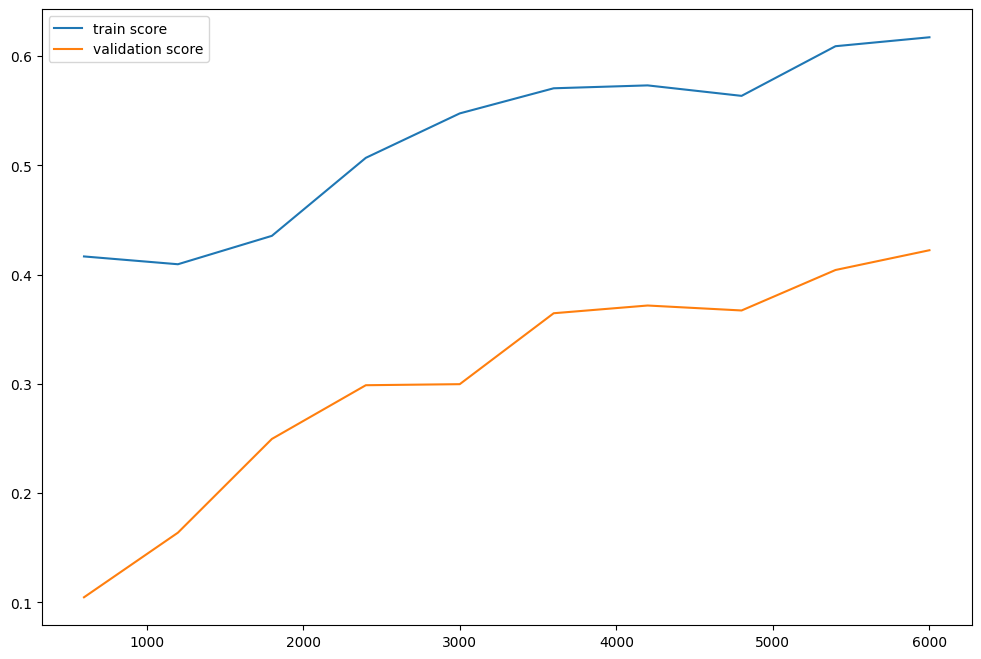

In [20]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

# Optimisation

In [21]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [22]:
xgb_pipe

,steps,"[('preprocessor', ...), ('xgb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('columntransformer', ...), ('selectkbest', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('type_encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3


In [23]:
xgb_pipe.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('type_encoder',
                                                                   OrdinalEncoder(categories=[['L',
                                                                                               'M',
                                                                                               'H']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1),
                                                                   ['Type'])])),
                                 ('selectkbest', SelectKBest(k='all'))])),
                ('xgb',
              

In [35]:
param_dist_xgb = {
    "xgb__n_estimators": [200, 300, 400],
    "xgb__max_depth": [10, 15],
    "xgb__scale_pos_weight": [1, 2],
    "xgb__learning_rate": [0.012, 0.014],
    # 'preprocessor__selectkbest__k':["all", 4, 6],
}

In [ ]:
param_dist_randomforest = {
    "rf__n_estimators": [700, 800, 900],
    "rf__max_depth": [11, 12, 13],
    "rf__min_samples_leaf": [3, 4, 5],
    "rf__class_weight": ['balanced'],
    # 'preprocessor__selectkbest__k':["all", 4, 6],
}

In [26]:
models_to_optimize = {
    "RandomForest": {
        "pipeline": RandomForest,      
        "params": param_dist_randomforest        
    },
    "XGBoost": {
        "pipeline": xgb_pipe,      
        "params": param_dist_xgb       
    }
}

Optimisation de RandomForest en cours...


/home/simon/projects/predictive_maintenance_dataset_AI4I_2020/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 27 is smaller than n_iter=500. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Meilleurs params pour RandomForest: {'rf__n_estimators': 800, 'rf__min_samples_leaf': 4, 'rf__max_depth': 12, 'rf__class_weight': 'balanced'}
[[1915   10]
 [  18   57]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1925
           1       0.85      0.76      0.80        75

    accuracy                           0.99      2000
   macro avg       0.92      0.88      0.90      2000
weighted avg       0.99      0.99      0.99      2000

------------------------------
Optimisation de XGBoost en cours...


/home/simon/projects/predictive_maintenance_dataset_AI4I_2020/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 54 is smaller than n_iter=500. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Meilleurs params pour XGBoost: {'xgb__scale_pos_weight': 1, 'xgb__n_estimators': 300, 'xgb__max_depth': 15, 'xgb__learning_rate': 0.012}
[[1920    5]
 [  23   52]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1925
           1       0.91      0.69      0.79        75

    accuracy                           0.99      2000
   macro avg       0.95      0.85      0.89      2000
weighted avg       0.99      0.99      0.99      2000

------------------------------


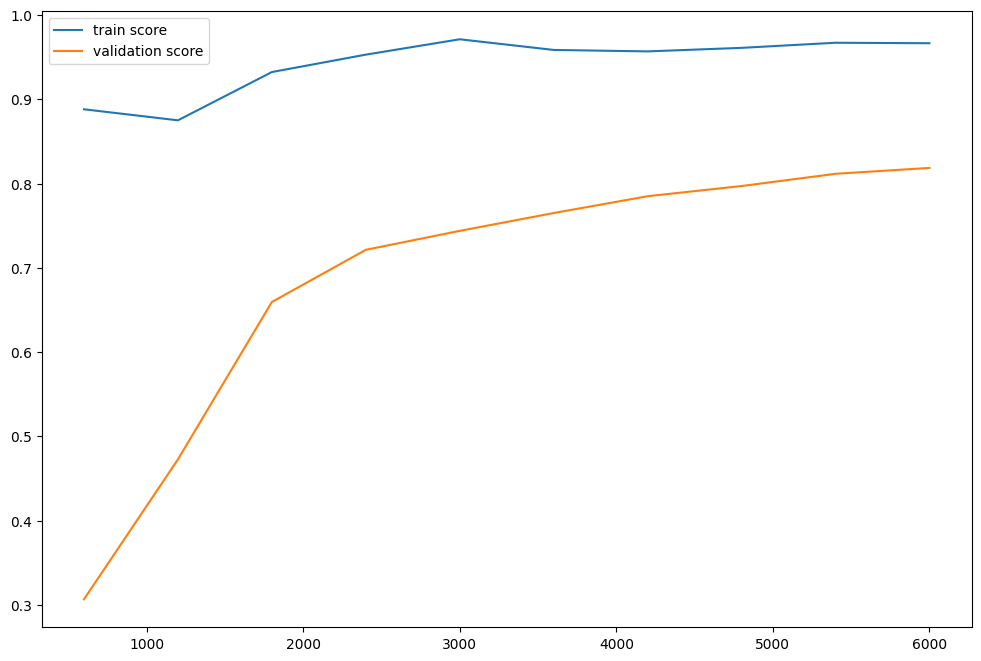

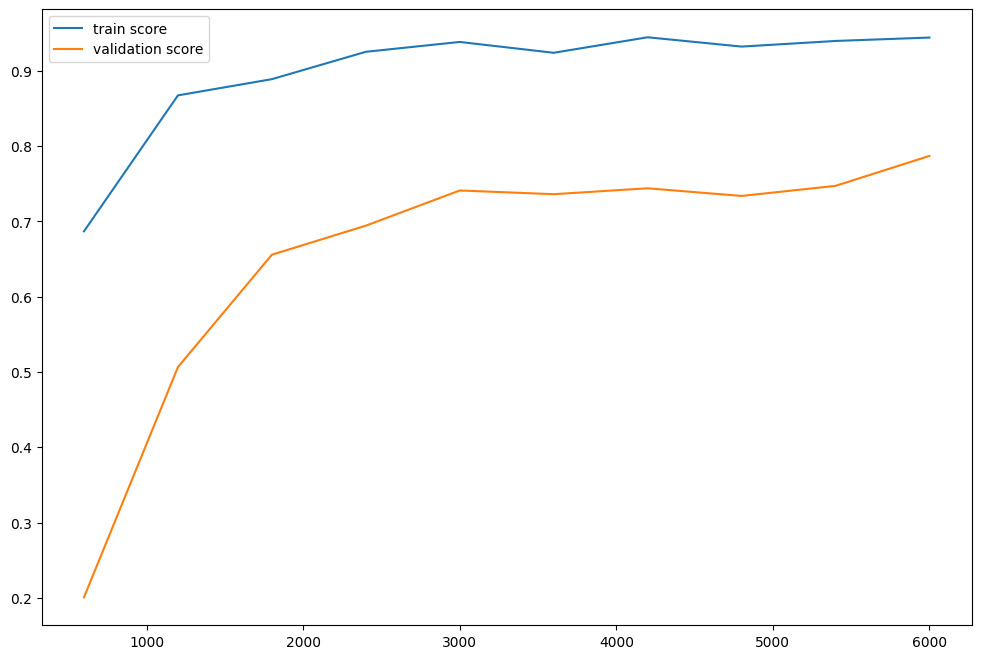

In [27]:
# Dictionnaire pour stocker les résultats finaux
best_models = {}

for model_name, config in models_to_optimize.items():
    print(f"Optimisation de {model_name} en cours...")
    
    # On récupère le pipeline et les params grâce aux sous-clés
    model = config["pipeline"]
    params = config["params"]

    grid = RandomizedSearchCV(model, params, scoring='f1', cv=5 ,n_jobs=6, n_iter=500)
    grid.fit(X_train, y_train)
    # On sauvegarde le gagnant
    best_models[model_name] = grid.best_estimator_
    
    # print(classification_report(y_test, y_pred))
    
    print(f"Meilleurs params pour {model_name}: {grid.best_params_}")
    evaluation(grid.best_estimator_)
    print("-" * 30)

In [28]:
# On récupère le meilleur Random Forest entraîné
best_rf = best_models["RandomForest"]

In [29]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve, f1_score

# 1. Générer des probabilités "propres" sur le TRAIN set via Cross-Validation
# Le modèle apprend sur des plis et prédit sur d'autres. C'est fair-play.
y_scores_cv = cross_val_predict(best_rf, X_train, y_train, cv=10, method="predict_proba")[:, 1]

# 2. Trouver le meilleur seuil sur ces prédictions CV
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_cv)

f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Seuil optimal trouvé (via Cross-Val sur Train) : {best_threshold:.3f}")

# 3. APPLIQUER ce seuil sur le Test Set (Le moment de vérité)
# On ne change plus le seuil maintenant, on regarde juste le résultat.
y_test_probs = best_rf.predict_proba(X_test)[:, 1]
y_test_pred_optim = (y_test_probs >= best_threshold).astype(int)

from sklearn.metrics import classification_report
print("\n--- RÉSULTATS FINAUX  ---")
print(classification_report(y_test, y_test_pred_optim))

Seuil optimal trouvé (via Cross-Val sur Train) : 0.548

--- RÉSULTATS FINAUX  ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1925
           1       0.90      0.73      0.81        75

    accuracy                           0.99      2000
   macro avg       0.95      0.87      0.90      2000
weighted avg       0.99      0.99      0.99      2000



In [30]:
f1_score(y_test, y_test_pred_optim)

0.8088235294117647

In [31]:
y_test_pred = best_rf.predict(X_test)
f1_score(y_test, y_test_pred)

0.8028169014084507

In [32]:
# 1. Modèle par défaut (Seuil 0.5)
print("--- AVANT OPTIMISATION (Seuil 0.5) ---")
print(classification_report(y_test, y_test_pred))

# 2. Modèle optimisé (Ton seuil calculé)
print(f"--- APRÈS OPTIMISATION (Seuil {best_threshold:.3f}) ---")
y_pred_optim = (best_rf.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_optim))

--- AVANT OPTIMISATION (Seuil 0.5) ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1925
           1       0.85      0.76      0.80        75

    accuracy                           0.99      2000
   macro avg       0.92      0.88      0.90      2000
weighted avg       0.99      0.99      0.99      2000

--- APRÈS OPTIMISATION (Seuil 0.548) ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1925
           1       0.90      0.73      0.81        75

    accuracy                           0.99      2000
   macro avg       0.95      0.87      0.90      2000
weighted avg       0.99      0.99      0.99      2000



# Entraînement sur tout le dataset

In [33]:
X_df, y_df = preprocessing(df)

Machine failure
0    9661
1     339
Name: count, dtype: int64


In [38]:
best_rf.fit(X_df, y_df)

,steps,"[('preprocessor', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('columntransformer', ...), ('selectkbest', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('type_encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3


In [36]:
from sklearn.utils import resample
from sklearn.metrics import f1_score
import numpy as np

def get_confidence_interval(y_true, y_pred, n_iterations=1000, confidence=0.95):
    scores = []
    
    # On répète l'opération 1000 fois
    for i in range(n_iterations):
        # On tire un échantillon au hasard (avec remise)
        # C'est comme si on simulait 1000 jeux de tests différents
        y_true_resampled, y_pred_resampled = resample(y_true, y_pred, random_state=i)
        
        # On calcule le score sur cet échantillon
        score = f1_score(y_true_resampled, y_pred_resampled)
        scores.append(score)
    
    # On trie les scores pour trouver les bornes
    scores.sort()
    
    # On calcule les index pour couper à 2.5% et 97.5% (pour un total de 95%)
    lower_idx = int(n_iterations * (1 - confidence) / 2)
    upper_idx = int(n_iterations * (1 + confidence) / 2)
    
    return scores[lower_idx], scores[upper_idx], scores

# --- Utilisation ---
# Assure-toi d'utiliser tes dernières prédictions optimisées
# y_test : Les vraies valeurs
# y_pred_optim : Tes prédictions avec le seuil 0.548

lower, upper, all_scores = get_confidence_interval(y_test, y_pred_optim)

print(f"F1-Score moyen : {np.mean(all_scores):.3f}")
print(f"Intervalle de confiance à 95% : [{lower:.3f} - {upper:.3f}]")

F1-Score moyen : 0.808
Intervalle de confiance à 95% : [0.729 - 0.874]
